如果你是使用Vscode打开这个文件，请确保已经在拓展中安装了Jupyter插件，然后在右上角的'Select Kernel'中选择我们已经创建的conda环境。

# 仿真的基本概念与方法

如果你已经对控制系统有所了解，那么你可能会知道，对于真实世界中物体的运动，都可以使用一个微分方程（组）来描述，即：

$$
\dot{x}(t) = f(x(t), u(t))
$$

其中，$x\in \mathbb{R}^n$ 是状态变量，$u\in \mathbb R^{m}$ 是输入变量，$\dot{x}$ 是状态变量对时间的导数。例如，对于经典的弹簧-质量-阻尼系统，可以用如下的微分方程来描述：

$$
m\ddot{\mathbf x(t)} + b\dot{\mathbf x(t)} + k\mathbf x(t) = \mathbf F(t)
$$

其中，$m$ 是质量，$b$ 是阻尼系数，$k$ 是弹簧系数，$\mathbf F$ 是外力, $\mathbf x$ 是位置，$\dot{\mathbf x}$ 是速度，$\ddot{\mathbf x}$ 是加速度。按照如下方式选择状态变量和输入变量：

$$
x = \begin{bmatrix} \mathbf  x \\ \dot{\mathbf x} \end{bmatrix} \in \mathbb R^2, \quad u = \begin{bmatrix} \mathbf F \end{bmatrix} \in \mathbb R^1
$$

这样，我们就可以将上述微分方程写成如下形式：

$$
\dot{x} = \begin{bmatrix} \dot{\mathbf x} \\ \ddot{\mathbf x} \end{bmatrix} = \begin{bmatrix} \dot{\mathbf x} \\ -\frac{b}{m}\dot{\mathbf x} - \frac{k}{m}\mathbf x + \frac{1}{m}\mathbf F \end{bmatrix} = f(x, u)
$$

进一步整理，可以得到如下的线性系统：

$$
\dot{x}(t) = f(x(t), u(t)) = Ax(t) + Bu(t)
$$

其中，

$$
A = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{b}{m} \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}
$$

上面的微分方程给出的是当前时刻系统状态的变化率与当前时刻的状态和输入的关系，但是我们希望在已知：

* 初始状态 $x_0 = x(0)$
* 输入 $u(t)$ 在 $[0, T]$ 时间段内的取值，即 $u(t)$ 关于时间的函数

的情况下，求解状态变量 $x(t)$ 在 $[0, T]$ 时间段内的取值，即 $x(t)$ 关于时间的函数。

如果你已经学过了微分方程的求解，那么你可能会知道，对于线性系统，上述问题具有解析解，即：

$$
x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau
$$

然而，大部分情况下，系统的微分方程是非线性的，或者是线性的但是 $A$ 和 $B$ 是时间变化的，这样的情况下，我们就无法得到解析解，只能通过数值方法来求解。

以下，我们将用数值方法，求解出$x(t)$ 关于时间的函数。

我们先在Python代码中实现上述的线性系统

In [1]:
# 首先，我们导入了numpy库，这是一个专门用于数学计算的库
import numpy as np
import matplotlib.pyplot as plt

# 根据微分方程\dot{x} = f(x, u)，我们定义了一个Python函数，用于表示f(x, u)
def dynamics(params:dict, x:np.ndarray, u:np.ndarray) -> np.ndarray:
    """
    这个函数用于计算状态向量x的导数\dot{x} = f(x, u)

    Args:
        params (dict): 一个字典，包含了系统的参数，即矩阵A和B
        x (np.ndarray): 状态向量
        u (np.ndarray): 输入向量
    """
    A = params['A']
    B = params['B']
    return A @ x + B @ u

# 我们可以测试一下这个函数
A = np.array([[0, 1], [-1, -1]])
B = np.array([[0], [1]])
params = {'A': A, 'B': B}
x = np.array([1, 1])
u = np.array([1])
assert np.allclose(dynamics(params, x, u), np.array([1, -1]))

## 前向欧拉法

上面的微分方程描述的是一种连续的关系，但是在现代的计算机中，我们只能处理离散的数据，因此，我们需要将上述微分方程转化为差分方程。最简单的方法是前向欧拉法，即：

$$
x(t + \Delta t) = x(t) + \Delta t\cdot f(x(t), u(t))
$$

或者，我们也可以用序号$k$代替时间$t$，即：

$$
x_{k+1} = x_k + \Delta t\cdot f(x_k, u_k)
$$

我们在下面的代码中，将前向欧拉法封装成一个函数，用来求解上述微分方程。

In [2]:
def forward_euler(params:dict, ode:callable, x:np.ndarray, u:np.ndarray, dt:float) -> np.ndarray:
    """
    这个函数用于计算状态向量x在时间间隔dt后的状态

    Args:
        params (dict): 一个字典，包含了系统的参数
        ode (callable): 一个函数，用于计算状态向量x的导数\dot{x} = f(x, u)
        x (np.ndarray): 状态向量
        u (np.ndarray): 输入向量
        dt (float): 时间间隔
    """
    return x + ode(params, x, u) * dt

接下来，使用前向欧拉法，仿真一个简单的弹簧-质量-阻尼系统，这里我们暂时先不考虑系统的输入。假设质量$m=1$，阻尼系数$b=0.1$，弹簧系数$k=1$，外力$\mathbf F(t) = 0$，初始位置$x(0) = 1$，初始速度$\dot{\mathbf x}(0) = 0$，仿真时间$T=100$，时间步长$\Delta t = 0.01$。

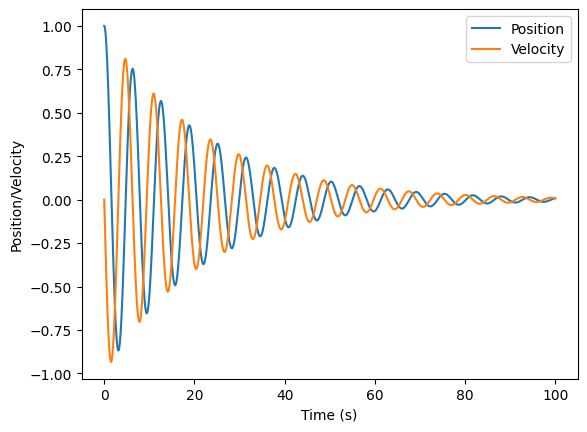

In [3]:
m = 1.0
b = 0.1
k = 1.0
A = np.array([[0, 1], [-k/m, -b/m]])
B = np.array([[0], [1/m]])
params = {'A': A, 'B': B}

dt = 0.01
total_time = 100 # seconds
num_steps = int(total_time / dt)

x_series = np.zeros((num_steps, 2)) # 用于存储状态向量x
t_series = np.zeros((num_steps, 1)) # 用于存储时间

x = np.array([1, 0]) # 初始状态，位置为1，速度为0
x_series[0] = x
t_series[0] = 0

for i in range(num_steps-1):
    u = np.array([0]) # 输入为0
    x = forward_euler(params, dynamics, x, u, dt)
    x_series[i+1] = x
    t_series[i+1] = t_series[i] + dt

# 我们可以绘制出位置和速度随时间的变化
plt.figure()
plt.plot(t_series, x_series[:, 0], label='Position')
plt.plot(t_series, x_series[:, 1], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Position/Velocity')
plt.legend()
plt.show()

由上图可知，弹簧-质量-阻尼系统的位置与速度随时间的变化，呈现出一种振荡衰减的特性。这与我们的直观感受是一致的，即弹簧-质量-阻尼系统在没有外力的情况下，会在初始位置附近振荡，但是由于阻尼的存在，振幅会逐渐减小，最终停止振荡。

前向欧拉法虽然简单直接，但是它存在一定的数值误差，请看下面这种情况。

考虑零阻尼的情况，即阻尼系数$b=0.0$，其他参数不变，仿真如下：

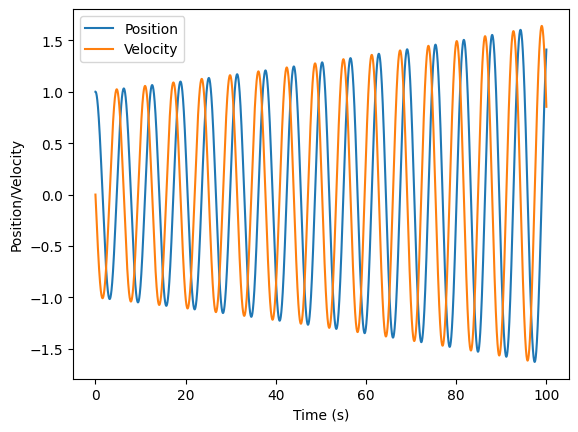

In [4]:
m = 1.0
b = 0.0 # 无阻尼
k = 1.0
A = np.array([[0, 1], [-k/m, -b/m]])
B = np.array([[0], [1/m]])
params = {'A': A, 'B': B}

dt = 0.01
total_time = 100 # seconds
num_steps = int(total_time / dt)

x_series = np.zeros((num_steps, 2)) # 用于存储状态向量x
t_series = np.zeros((num_steps, 1)) # 用于存储时间

x = np.array([1, 0]) # 初始状态，位置为1，速度为0
x_series[0] = x
t_series[0] = 0

for i in range(num_steps-1):
    u = np.array([0]) # 输入为0
    x = forward_euler(params, dynamics, x, u, dt)
    x_series[i+1] = x
    t_series[i+1] = t_series[i] + dt

# 我们可以绘制出位置和速度随时间的变化
plt.figure()
plt.plot(t_series, x_series[:, 0], label='Position')
plt.plot(t_series, x_series[:, 1], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Position/Velocity')
plt.legend()
plt.show()

在这种情况下，仿真的结果与我们的预期是不同的：在理论上，零阻尼的弹簧-质量系统应该会一直稳定地等幅振荡，但是在仿真结果中，我们看到，位置和速度都在不断增大，有发散的趋势，这是因为前向欧拉法的数值误差导致的。

## 龙格-库塔法

我们考虑另一种常用的数值方法：龙格-库塔法（Runge-Kutta method）。龙格-库塔法是一种常用的数值积分方法，它的基本思想是：通过多次计算微分方程，然后取平均值，来减小数值误差。龙格-库塔法的一种形式是四阶龙格-库塔法，它的计算公式如下：

$$
\begin{aligned}
k_1 &= f(x_k, u_k) \\
k_2 &= f(x_k + \frac{\Delta t}{2}k_1, u_k) \\
k_3 &= f(x_k + \frac{\Delta t}{2}k_2, u_k) \\
k_4 &= f(x_k + \Delta t k_3, u_k) \\
x_{k+1} &= x_k + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{aligned}

In [5]:
def runge_kutta_4th_order(params:dict, ode:callable, x:np.ndarray, u:np.ndarray, dt:float) -> np.ndarray:
    """
    这个函数用于计算状态向量x在时间间隔dt后的状态

    Args:
        params (dict): 一个字典，包含了系统的参数
        ode (callable): 一个函数，用于计算状态向量x的导数\dot{x} = f(x, u)
        x (np.ndarray): 状态向量
        u (np.ndarray): 输入向量
        dt (float): 时间间隔
    """
    k1 = ode(params, x, u)
    k2 = ode(params, x + k1 * dt / 2, u)
    k3 = ode(params, x + k2 * dt / 2, u)
    k4 = ode(params, x + k3 * dt, u)
    return x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6

我们可以测试一下四阶龙格-库塔法在零阻尼的弹簧-质量系统上的效果。

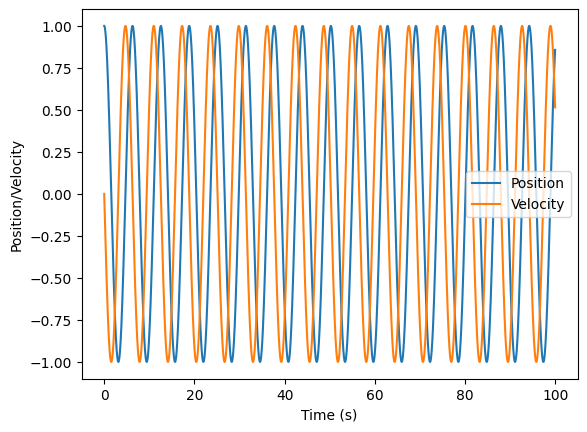

In [6]:
m = 1.0
b = 0.0 # 无阻尼
k = 1.0
A = np.array([[0, 1], [-k/m, -b/m]])
B = np.array([[0], [1/m]])
params = {'A': A, 'B': B}

dt = 0.01
total_time = 100 # seconds
num_steps = int(total_time / dt)

x_series = np.zeros((num_steps, 2)) # 用于存储状态向量x
t_series = np.zeros((num_steps, 1)) # 用于存储时间

x = np.array([1, 0]) # 初始状态，位置为1，速度为0
x_series[0] = x
t_series[0] = 0

for i in range(num_steps-1):
    u = np.array([0]) # 输入为0
    x = runge_kutta_4th_order(params, dynamics, x, u, dt)
    x_series[i+1] = x
    t_series[i+1] = t_series[i] + dt

# 我们可以绘制出位置和速度随时间的变化
plt.figure()
plt.plot(t_series, x_series[:, 0], label='Position')
plt.plot(t_series, x_series[:, 1], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Position/Velocity')
plt.legend()
plt.show()

由图可以看出，四阶龙格-库塔法的仿真结果与我们的预期是一致的：零阻尼的弹簧-质量系统会一直稳定地等幅振荡。

## 非线性系统的仿真

上面我们针对线性系统进行了仿真，但是实际的系统往往是非线性的。这里我们考虑著名的Van der Pol振荡器，它的微分方程如下（请注意区别这里的粗体和非粗体字母）：

$$
\begin{aligned}
\dot{\mathbf{x}} = \mathbf{y} \\
\dot{\mathbf{y}} = \mu(1-\mathbf{x}^2)\mathbf{y} - \mathbf{x}
\end{aligned}
$$

其中$\mu$ 是一个参数。将其写成上面的形式，我们可以得到：

$$
\dot{x} = \begin{bmatrix} \dot{\mathbf{x}} \\ \dot{\mathbf{y}} \end{bmatrix} = \begin{bmatrix} \mathbf{y} \\ \mu(1-\mathbf{x}^2)\mathbf{y} - \mathbf{x} \end{bmatrix} = f(x)
$$

其中状态变量$x = [\mathbf{x}, \mathbf{y}]^\top$，函数$f(x)$ 是非线性的，这里没有输入变量。我们可以仿真这个非线性系统，看看其行为。

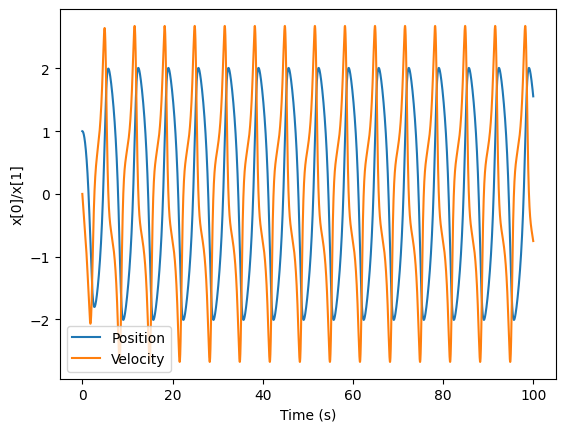

In [17]:
def van_der_pol_dynamics(params:dict, x:np.ndarray, u:np.ndarray) -> np.ndarray:
    """
    这个函数用于计算状态向量x的导数\dot{x} = f(x, u)

    Args:
        params (dict): 一个字典，包含了系统的参数，即矩阵A和B
        x (np.ndarray): 状态向量
        u (np.ndarray): 输入向量
    """
    mu = params['mu']
    return np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])

mu = 1.0
params = {'mu': mu}

dt = 0.01
total_time = 100 # seconds
num_steps = int(total_time / dt)

x_series = np.zeros((num_steps, 2)) # 用于存储状态向量x
t_series = np.zeros((num_steps, 1)) # 用于存储时间

x = np.array([1, 0]) # 初始状态，位置为1，速度为0
x_series[0] = x
t_series[0] = 0

for i in range(num_steps-1):
    u = np.array([0]) # 输入为0
    x = runge_kutta_4th_order(params, van_der_pol_dynamics, x, u, dt)
    x_series[i+1] = x
    t_series[i+1] = t_series[i] + dt

# 我们可以绘制出位置和速度随时间的变化
plt.figure()
plt.plot(t_series, x_series[:, 0], label='Position')
plt.plot(t_series, x_series[:, 1], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('x[0]/x[1]')
plt.legend()
plt.show()

可以看出，$\mathbf{x}$和$\mathbf{y}$均表现出周期震荡的特性，下面我们以$\mathbf{x}$为横轴，$\mathbf{y}$为纵轴，画出相图。

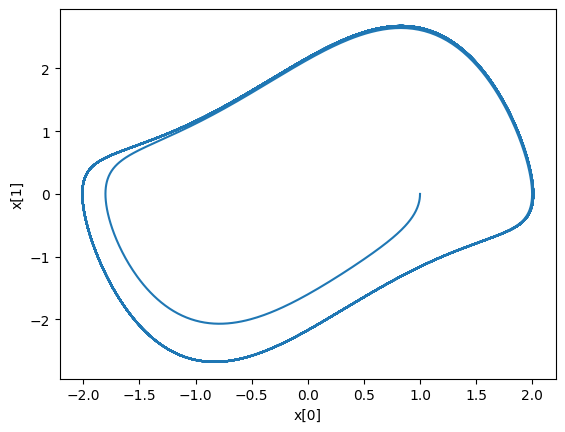

In [18]:
plt.figure()
plt.plot(x_series[:, 0], x_series[:, 1])
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

这个非线性系统实际上形成了一个极限环，你可以试着改变$x$的初始值，看看系统的行为会如何变化。